In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import statsmodels.tsa.api as sm

# Load the Henry's fork discharge dataset
df = pd.read_pickle('../data/HenrysForkDischarge_WY2001-2015.pkl')

# Create a Water Year column for our pandas data frame. This is a pretty 
# simple thing to do, but may not be necessary if you're not dealing with
# discharge data. Here's how it goes:
# 1. Create an empty array that is full of zeros and equal in length to 
#    the number of days in the record
WY = np.zeros(len(df['Y'].index)) 
# 2. For those records where the month is less than 10, their associated 
#    year is the correct water year
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] 
# 3. For those records where the month is greater than or equal to 10, 
#    the correct water year is one more than the current calendar year
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1
# 4. Save the water year array as a column in the pandas data frame, as an
#    integer
df['WY'] = WY.astype(int)

# Print the first and last 10 records just to make sure we loaded the data okay
qrows = np.concatenate([np.arange(0,10,1),np.arange(-11,-1,1)])
df.iloc[qrows,:]

,Y,M,D,Q,SerDates,WY
0,2000,10,1,39.361853,2000-10-01,2001
1,2000,10,2,39.361853,2000-10-02,2001
2,2000,10,3,37.945959,2000-10-03,2001
3,2000,10,4,37.945959,2000-10-04,2001
4,2000,10,5,37.379601,2000-10-05,2001
5,2000,10,6,36.813243,2000-10-06,2001
6,2000,10,7,37.096422,2000-10-07,2001
7,2000,10,8,36.813243,2000-10-08,2001
8,2000,10,9,38.512316,2000-10-09,2001
9,2000,10,10,37.662780,2000-10-10,2001


In [103]:
# In the following example, we're going to segment the whole dataframe
# into a training dataset (everything that's not Water Year 2015) and
# a test dataset (everything that is Water Year 2015).
df_train = df[df.WY != 2015]
df_test  = df[df.WY == 2015]


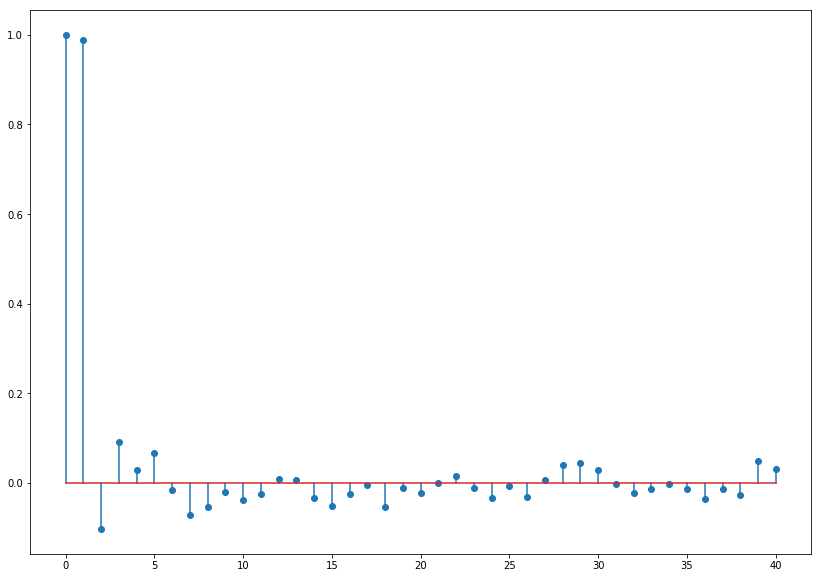

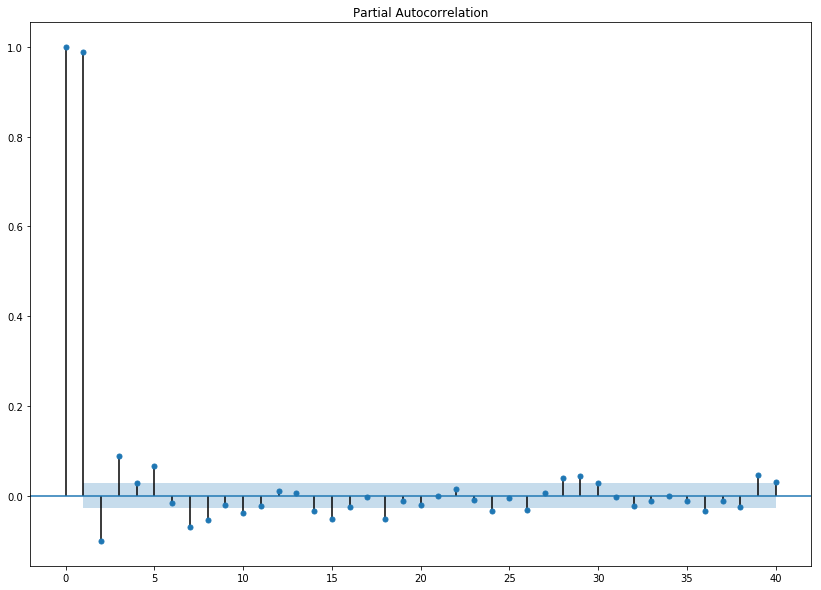

In [154]:
Qt = pd.Series(df_train['Q'].values,df_train['SerDates'].values)

Qpacf = sm.pacf(Qt)

plt.figure(figsize=(14,10))
plt.stem(Qpacf)
plt.show()

from statsmodels.graphics.tsaplots import plot_pacf
f, axarr = plt.subplots(1, 1, figsize=(14,10))
_ = plot_pacf(Qt,method='ols',lags=40,ax=axarr.axes)


In [106]:
Q_AR1_model = sm.AR(Qt).fit(1)
print(Q_AR1_model.params)

const    0.502767
L1.y     0.987884
dtype: float64


In [107]:
Q_AR2_model = sm.AR(Qt).fit(2)
print(Q_AR2_model.params)

const    0.554079
L1.y     1.088064
L2.y    -0.101412
dtype: float64


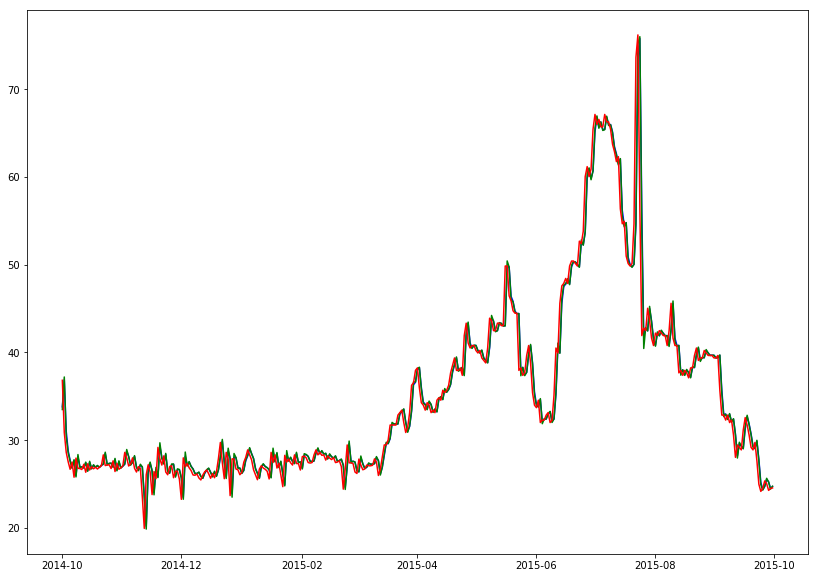

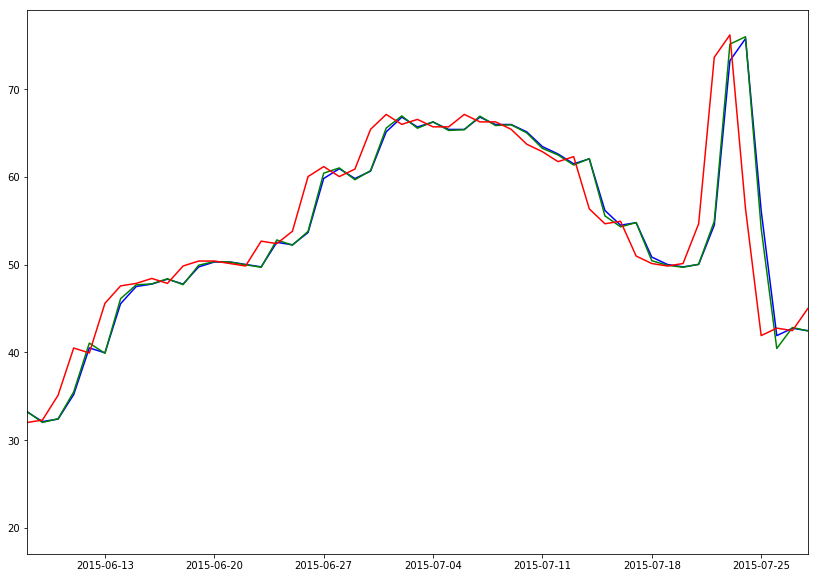

In [135]:
Qtrain = df_train['Q'].values
Qtest  = df_test['Q'].values

DatesTest = df_test['SerDates'].values

Qttm1 = np.concatenate([Qtrain[-2:-1],Qtest[0:-1]])
Qttm2 = np.concatenate([Qtrain[-3:-1],Qtest[0:-2]])

AR1_mu   = Q_AR1_model.params[0]
AR1_phi1 = Q_AR1_model.params[1]

QhatAR1 = AR1_mu + AR1_phi1*Qttm1

AR2_mu   = Q_AR2_model.params[0]
AR2_phi1 = Q_AR2_model.params[1]
AR2_phi2 = Q_AR2_model.params[2]

QhatAR2 = AR2_mu + AR2_phi1*Qttm1 + AR2_phi2*Qttm2

plt.figure(figsize=(14,10))
plt.plot(DatesTest,QhatAR1,'b-')
plt.plot(DatesTest,QhatAR2,'g-')
plt.plot(DatesTest,Qtest,'r-')
plt.show()

plt.figure(figsize=(14,10))
plt.plot(DatesTest,QhatAR1,'b-')
plt.plot(DatesTest,QhatAR2,'g-')
plt.plot(DatesTest,Qtest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.show()